### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系


In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy

sys.path.append("../")
# from models.Cars import Cars

In [30]:
# 初期設定（独立変数群）
CAR_NUM = 10 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
TIME_STEP = 1
TOTAL_TIME = 100
V_MAX = 40
GLOBAL_TIME_WINDOW = 60  # Strategic Phaseでの時間幅
TTC = 2 #車間時間を暫定的に定義


In [57]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])
# arrival_times = [15.3, 27.1, 48.66, 54.83, 55.63]
CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED)
              for index, time in enumerate(arrival_times)]

cwp_table = CWPTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})

In [150]:
cwp_table = CWPTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
# 各車がETAを決める部分
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = cwp_table.validate(desired_eta_list)
    if is_valid:
        cwp_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = cwp_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        df_to_add = pd.DataFrame(calibrated_list)
        cwp_table.register(calibrated_list)



In [151]:
# cwp_table.waypoint_table
def create_noise(**kwargs):
    start_time = kwargs.get("time_step")
    TOTAL_LENGTH = kwargs.get("TOTAL_LENGTH")
    if start_time == None or TOTAL_LENGTH == None:
        raise ValueError("start_time, TOTAL_LENGTHが入力されていません")
    expected_noise_period = kwargs.get("expected_noise_period",10)
    return {"x":[610, 730], "t":[40,50]}
    
    

#### ここからノイズを入れたシミュレーションを開始

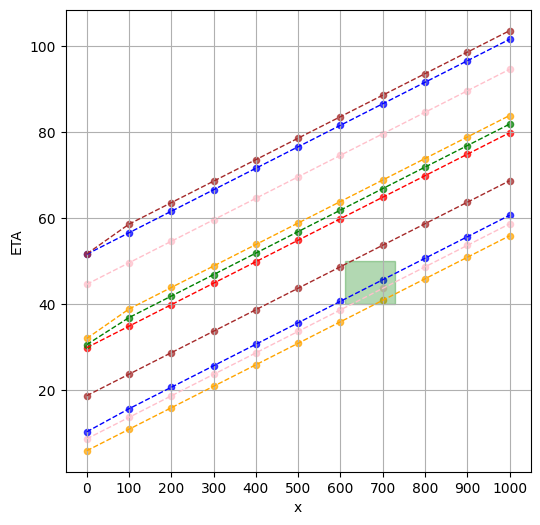

In [152]:
initial_cwp = copy.deepcopy(cwp_table)
noise = create_noise(time_step=20,TOTAL_LENGTH=1000)
cwp_table.plot_with_noise([noise])


In [157]:
df = cwp_table.waypoint_table
new_eta = [10] * 11
cwp_table.update_with_request(car_idx=0, new_eta=new_eta)
cwp_table.waypoint_table

11


,waypoint_idx,x,eta,car_idx
0,0,0.0,8.608595,1
1,1,100.0,13.608595,1
2,2,200.0,18.608595,1
3,3,300.0,23.608595,1
4,4,400.0,28.608595,1
...,...,...,...,...
105,6,600.0,10.000000,0
106,7,700.0,10.000000,0
107,8,800.0,10.000000,0
108,9,900.0,10.000000,0


In [142]:
print(cwp_table.waypoint_table)
df = cwp_table.waypoint_table
car_0 = df[df["car_idx"] == 0].copy()
print(len(car_0))
car_0['eta'] = [3,4,5,6,7,8,9,0,1,2,3]

# print(car_0)
# 元のDataFrameからcar_idxが0の行を削除
new_df = df[df['car_idx'] != 0]

# 更新された部分集合を元のDataFrameに追加
new_df = pd.concat([new_df, car_0], ignore_index=True)
print(new_df)

    waypoint_idx       x         eta  car_idx
0              0     0.0    5.838335        0
1              1   100.0   10.838335        0
2              2   200.0   15.838335        0
3              3   300.0   20.838335        0
4              4   400.0   25.838335        0
..           ...     ...         ...      ...
6              6   600.0   83.558879        9
7              7   700.0   88.558879        9
8              8   800.0   93.558879        9
9              9   900.0   98.558879        9
10            10  1000.0  103.558879        9

[110 rows x 4 columns]
11
     waypoint_idx       x        eta  car_idx
0               0     0.0   8.608595        1
1               1   100.0  13.608595        1
2               2   200.0  18.608595        1
3               3   300.0  23.608595        1
4               4   400.0  28.608595        1
..            ...     ...        ...      ...
105             6   600.0   9.000000        0
106             7   700.0   0.000000        0
107    

In [ ]:
"""
noiseの影響範囲にあたっている車はETAの変更を行う。
"""
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = cwp_table.validate(desired_eta_list)
    if is_valid:
        cwp_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = cwp_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        df_to_add = pd.DataFrame(calibrated_list)
        cwp_table.register(calibrated_list)

### モデル定義用

In [26]:
class Cars:
    def __init__(self, **kwagrs):
        self.eta_table = []
        self.arrival_time = kwagrs.get("arrival_time")
        self.index = kwagrs.get("index")
        self.mean_speed = kwagrs.get("mean_speed")
        self.xcor = 0
        self.v_x = kwagrs.get("mean_speed")

    def create_desired_eta(self, way_points):

        def calc_eta(way_points):
            estimated_time_of_arrival = way_points["x"] / self.mean_speed + self.arrival_time
            return {**way_points, "eta": estimated_time_of_arrival, "car_idx": self.index}
        way_points_with_eta = list(map(calc_eta, way_points))

        return way_points_with_eta

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class GlobalParams:
    DESIRED_TTC: float

class CWPTable:
    def __init__(self, **kwargs) -> None:
        self.waypoints = kwargs.get("waypoints")
        self.waypoint_table = pd.DataFrame([])
        self.global_params = GlobalParams(**kwargs.get("global_params"))

    def validate(self, waypoints_with_eta):
        result = self.validate_with_ttc(waypoints_with_eta)
        return result


    def validate_with_ttc(self, waypoints_with_eta):
        df = self.waypoint_table
        if df.shape[0] < 1:
            return True

        is_valid = True
        for idx, waypoint_info in enumerate(waypoints_with_eta):
            if idx == 0:
                continue

            target_waypoint = waypoint_info["waypoint_idx"]
            filtered_df = df[df["waypoint_idx"] == target_waypoint]
            last_entry_time = filtered_df["eta"].max()
            if waypoint_info["eta"] > last_entry_time + self.global_params.DESIRED_TTC:
                continue
            else:
                is_valid = False
                break
        return is_valid

    def calibrate_list(self, **kwargs):
        df = self.waypoint_table
        calibrated_list = []
        if "desired_list" not in kwargs:
            raise ValueError("キーワード引数 'desired_list' が必要です。")

        waypoints_with_eta = kwargs.get("desired_list")

        for idx, waypoint_info in enumerate(waypoints_with_eta):
            if idx == 0:
                calibrated_list.append(waypoint_info)
                continue
            target_waypoint_idx = waypoint_info["waypoint_idx"]
            filtered_df = df[df["waypoint_idx"] == target_waypoint_idx]
            # ここから時間の比較
            last_entry_time = filtered_df["eta"].max()
            desired_entry_time = waypoint_info["eta"]
            if (desired_entry_time < last_entry_time + self.global_params.DESIRED_TTC):
                entry_time = last_entry_time + self.global_params.DESIRED_TTC
            else:
                entry_time = desired_entry_time
            calibrated_list.append({**waypoint_info, "eta": entry_time})
        speed_profile = []
        return calibrated_list, speed_profile

    def register(self, waypoints_with_eta):
        df_to_add = pd.DataFrame(waypoints_with_eta)
        combined_df = pd.concat([self.waypoint_table, df_to_add])
        self.waypoint_table = combined_df

    def update_with_request(self, **request):
        df = self.waypoint_table
        car_idx = request.get("car_idx")
        new_eta = request.get("new_eta")
        if car_idx == None or new_eta == None:
            raise ValueError("car_idx and new_eta must be specified in the request")
        car_0 = df[df["car_idx"] == car_idx].copy()
        print(len(car_0))
        car_0['eta'] = new_eta
        
        new_df = df[df['car_idx'] != car_idx]
        # 更新された部分集合を元のDataFrameに追加
        new_df = pd.concat([new_df, car_0], ignore_index=True)
        self.waypoint_table = new_df

    """
    If noise_list is empty [], it just plots ETAs of each car.
    """
    def plot_with_noise(self, noise_list):
        color_list = ["orange", "pink", "blue", "brown", "red", "green"]
        car_idx_list = self.waypoint_table["car_idx"].unique()
        waypoints = self.waypoint_table["x"].unique()

        plt.figure(figsize=(6, 6))
        ax = plt.gca()

        # 既存のプロットロジック
        for car_idx in car_idx_list:
            _df = self.waypoint_table
            df_by_car = _df[_df["car_idx"] == car_idx]
            plt.plot(df_by_car["x"], df_by_car["eta"], color=color_list[car_idx % 6], linewidth=1, linestyle='--')
            plt.scatter(df_by_car["x"], df_by_car["eta"], color=color_list[car_idx % 6], alpha=0.7, s=20)

        # ノイズ領域の描画
        for noise in noise_list:
            x_range = noise["x"]
            t_range = noise["t"]
            width = x_range[1] - x_range[0]
            height = t_range[1] - t_range[0]
            rect = patches.Rectangle((x_range[0], t_range[0]), width, height, color='green', alpha=0.3)
            ax.add_patch(rect)

        # x軸の目盛り
        plt.xticks(waypoints)

        # 罫線を引く
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('ETA')

        plt.show()        


### ここから下はDebug用のセル

In [6]:
# Initialize
car_0 = CARS[0]
print(arrival_times)
car_0.arrival_time

[1.1514412675820007, 20.670029824891007, 21.993481994314482, 30.18365737679346, 35.091883812613865, 45.16063044492818, 46.75884290964873, 52.515749460062686, 52.90767092789682, 58.33068176234094]


1.1514412675820007